In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.mixture import GaussianMixture

In [68]:
dataPath = 'acousticbrainz-mediaeval-discogs-train.tsv'
data = pd.read_csv(dataPath, delimiter='\t')

/var/folders/6z/ms365n9s4t3fp5htj9nxj83w0000gn/T/ipykernel_9234/3191798550.py:2: DtypeWarning: Columns (17,18,19,20,21,22,23,24,25,26,27,28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dataPath, delimiter='\t')


In [69]:
print(data.keys())

Index(['recordingmbid', 'releasegroupmbid', 'genre1', 'genre2', 'genre3',
       'genre4', 'genre5', 'genre6', 'genre7', 'genre8', 'genre9', 'genre10',
       'genre11', 'genre12', 'genre13', 'genre14', 'genre15', 'genre16',
       'genre17', 'genre18', 'genre19', 'genre20', 'genre21', 'genre22',
       'genre23', 'genre24', 'genre25', 'genre26', 'genre27', 'genre28',
       'genre29', 'genre30'],
      dtype='object')


In [ ]:
data['is_rnb'] = data.filter(like='genre').apply(lambda x: x.str.contains('R&B|rnb', case=False, na=False)).any(axis=1).astype(int)

# once we decide which columns we want to drop from our features
dropCols = ['genre1', 'is_rnb']
X = data.drop(columns=data.columns[1:])
# Load the JSON files and extract features
def load_features(recordingmbid):
    try:
        with open(f'path_to_json_files/{recordingmbid}.json', 'r') as file:
            features = json.load(file)
            return features['desired_feature']  # Decided on what features to keep
    except FileNotFoundError:
        # return random number for now
        return np.NAN
    
# For now we use random numbers to represent the features we want from the JSON file
X['feature1'] = X['recordingmbid'].apply(load_features)
X['feature2'] = X['recordingmbid'].apply(lambda x: np.random.rand())
dropCols = ['recordingmbid']
X = X.drop(columns=dropCols)

y = data['is_rnb']


In [74]:
# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# scale the features added from the JSON file

# Select only numerical columns for scaling
numerical_cols = X_train.select_dtypes(include=[np.number]).columns

scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [ ]:
# Train one GMM for each class
# We fit a separate Gaussian Mixture Model for each class (0 and 1) to model the distribution of features for each class
gmm0 = GaussianMixture(n_components=1, covariance_type='full', random_state=42)
gmm1 = GaussianMixture(n_components=1, covariance_type='full', random_state=42)

# Ensure X_train and y_train are defined and properly filtered
gmm0.fit(X_train[y_train == 0])
gmm1.fit(X_train[y_train == 1])

GaussianMixture(random_state=42)

In [77]:
# Define a prediction function that assigns a label based on the higher log-likelihood
def gmm_predict(X):
    scores0 = gmm0.score_samples(X)
    scores1 = gmm1.score_samples(X)
    return np.where(scores1 > scores0, 1, 0)

# Make predictions on the test set
y_pred = gmm_predict(X_test)

# Evaluate performance
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.596643994938919
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.60      0.75    179389
           1       0.01      0.40      0.02      1600

    accuracy                           0.60    180989
   macro avg       0.50      0.50      0.38    180989
weighted avg       0.98      0.60      0.74    180989



In [78]:
def plot_points(features, labels):
    X_arr = np.array(features)
    y_arr = np.array(labels)
    # Separate the points by class
    spam = X_arr[np.argwhere(y_arr == 1)]
    ham = X_arr[np.argwhere(y_arr == 0)]
    plt.scatter([s[0][0] for s in spam],
                [s[0][1] for s in spam],
                s=35,
                color='cyan',
                edgecolor='k',
                marker='^')
    plt.scatter([s[0][0] for s in ham],
                [s[0][1] for s in ham],
                s=25,
                color='red',
                edgecolor='k',
                marker='s')
    plt.xlabel('x_1')
    plt.ylabel('x_2')
    plt.legend(['R&B (1)', 'Not R&B (0)'])

In [79]:
def plot_model(X, y, model):
    X_arr = np.array(X)
    y_arr = np.array(y)
    plot_step = 0.01
    x_min, x_max = X_arr[:, 0].min() - 1, X_arr[:, 0].max() + 1
    y_min, y_max = X_arr[:, 1].min() - 1, X_arr[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='k', linewidths=3)
    plot_points(X, y)
    plt.contourf(xx, yy, Z, colors=['red', 'blue'], alpha=0.2, levels=range(-1, 2))
    plt.title("GMM Decision Boundary")
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


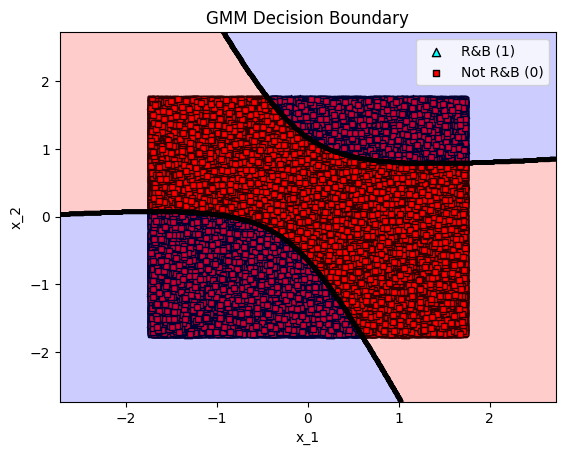

In [81]:
# Use the same GMMClassifier class
class GMMClassifier:
    def predict(self, X):
        return gmm_predict(X)

gmm_model = GMMClassifier()
plot_model(X_test, y_test, gmm_model)